# PilotNet Sigma-Delta Neural Network (SDNN) Training

<table><tr>
<td> <img src="images/pilotnet_steering_white.png" alt="Drawing" style="height: 200px;"/> </td>
<td> <img src="images/25093.jpg" alt="Drawing" style="height: 200px; width:600px"/> </td>
</tr>
</table>

<table><tr>
<td> <font size="+2"><b>PilotNet:</b> Predict the car's steering angle from the dashboard view. </font></td>
</tr>
<tr><td> PilotNet dataset is available freely <a href="https://github.com/lhzlhz/PilotNet/tree/master/data/datasets">here</a>. © MIT License.
</td>
</tr>
</table>

## What are SDNNs?
<table><tr>
<td> <img src="images/delta_encoder.png" alt="Drawing" style="height: 200px;"/> </td>
<td> <img src="images/sigma_decoder.png" alt="Drawing" style="height: 200px;"/> </td>
</tr></table>

__Sigma-delta neural networks__ consists of two main units: _sigma_ decoder in the dendrite and _delta_ encoder in the axon. Delta encoder uses differential encoding on the output activation of a regular ANN activation, for e.g. ReLU. In addition it only sends activation to the next layer when the encoded message magnitude is larger than its threshold. The sigma unit accumulates the sparse event messages and accumulates it to restore the original value.

<table><tr>
<!-- <td> <img src="images/sdnn.png" alt="Drawing" style="height: 300px;"/> </td> -->
<td> <img src="./images/sdnn.png" height="300"/> </td>
</tr></table>

A sigma-delta neuron is simply a regular activation wrapped around by a sigma unit at it's input and a delta unit at its output.

When the input to the network is a temporal sequence, the activations do not change much. Therefore, the message between the layers are reduced which in turn reduces the synaptic computation in the next layer. In addition, the graded event values can encode the change in magnitude in one time-step. Therefore there is no increase in latency at the cost of time-steps unlike the rate coded Spiking Neural Networks.

<table><tr>
<td> <img src="images/temporal_redundancy.png" alt="Drawing" style="height: 170px;"/> </td>
<td> <img src="images/sdnn_reconstruction.png" alt="Drawing" style="height: 170px;"/> </td>
</tr><tr>
<td> Credit Eadweard Muybridge <a href="https://commons.wikimedia.org/wiki/File:Muybridge_race_horse_animated.gif">© Public Domain</a> </td>
</tr></table>

<!-- TODO:
- Brief Overview of Sigma-Delta Network
- Add interesting figure describing SDNN
- Advantages of event based sparse computation
- Advantages compared to rate coded SNNs
- When are they useful -->



In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import h5py

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F

import lava.lib.dl.slayer as slayer

from pilotnet_dataset import PilotNetDataset
import utils

In [2]:
torch.manual_seed(4205)

# Event sparsity loss

Sparsity loss to penalize the network for high event-rate.

In [3]:
def event_rate_loss(x, max_rate=0.01):
    mean_event_rate = torch.mean(torch.abs(x))
    return F.mse_loss(F.relu(mean_event_rate - max_rate), torch.zeros_like(mean_event_rate))

# Network description

__SLAYER 2.0__ (__`lava.dl.slayer`__) provides a variety of learnable _neuron models_ <!-- (`slayer.neuron.{cuba, rf, ad_lif, __sigma_delta__, ...}`)  --> , _synapses_ <!-- (`slayer.{synapse, complex.synapse}.{dense, conv, pool, convT, unpool}`)  --> _axons_ and _dendrites_ that support quantized training. 
For easier use, it also provides __`block`__ interface which packages the associated neurons, synapses, axons and dendrite features into a single module. 

__Sigma-delta blocks__ are available as `slayer.blocks.sigma_delta.{Dense, Conv, Pool, Input, Output, Flatten, ...}` which can be easily composed to create a variety of sequential network descriptions as shown below. The blocks can easily enable _synaptic weight normalization_, _neuron normalization_ as well as provide useful _gradient monitoring_ utility and _hdf5 network export_ utility.

<!-- TODO:
- Describe how easy it is to describe a network in slayer2.0
- Parameter Quantization is automatically handled unless disabled
- Weight and neuron normalization
- gradient monitoring utility
- hdf5 export utility -->

These blocks can be used to create a network using standard PyTorch procedure.

In [4]:
class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        sdnn_params = { # sigma-delta neuron parameters
                'threshold'     : 0.1,    # delta unit threshold
                'tau_grad'      : 0.5,    # delta unit surrogate gradient relaxation parameter
                'scale_grad'    : 1,      # delta unit surrogate gradient scale parameter
                'requires_grad' : True,   # trainable threshold
                'shared_param'  : True,   # layer wise threshold
                'activation'    : F.relu, # activation function
            }
        sdnn_cnn_params = { # conv layer has additional mean only batch norm
                **sdnn_params,                                 # copy all sdnn_params
                'norm' : slayer.neuron.norm.MeanOnlyBatchNorm, # mean only quantized batch normalizaton
            }
        sdnn_dense_params = { # dense layers have additional dropout units enabled
                **sdnn_cnn_params,                        # copy all sdnn_cnn_params
                'dropout' : slayer.neuron.Dropout(p=0.2), # neuron dropout
            }
        
        self.blocks = torch.nn.ModuleList([# sequential network blocks 
                # delta encoding of the input
                slayer.block.sigma_delta.Input(sdnn_params), 
                # convolution layers
                slayer.block.sigma_delta.Conv(sdnn_cnn_params,  3, 24, 3, padding=0, stride=2, weight_scale=2, weight_norm=True),
                slayer.block.sigma_delta.Conv(sdnn_cnn_params, 24, 36, 3, padding=0, stride=2, weight_scale=2, weight_norm=True),
                slayer.block.sigma_delta.Conv(sdnn_cnn_params, 36, 64, 3, padding=(1, 0), stride=(2, 1), weight_scale=2, weight_norm=True),
                slayer.block.sigma_delta.Conv(sdnn_cnn_params, 64, 64, 3, padding=0, stride=1, weight_scale=2, weight_norm=True),
                # flatten layer
                slayer.block.sigma_delta.Flatten(),
                # dense layers
                slayer.block.sigma_delta.Dense(sdnn_dense_params, 64*40, 100, weight_scale=2, weight_norm=True),
                slayer.block.sigma_delta.Dense(sdnn_dense_params,   100,  50, weight_scale=2, weight_norm=True),
                slayer.block.sigma_delta.Dense(sdnn_dense_params,    50,  10, weight_scale=2, weight_norm=True),
                # linear readout with sigma decoding of output
                slayer.block.sigma_delta.Output(sdnn_dense_params,   10,   1, weight_scale=2, weight_norm=True)
            ])
        
        
    def forward(self, x):
        count = []
        event_cost = 0

        for block in self.blocks: 
            # forward computation is as simple as calling the blocks in a loop
            x = block(x)
            if hasattr(block, 'neuron'):
                event_cost += event_rate_loss(x)
                count.append(torch.sum(torch.abs((x[..., 1:]) > 0).to(x.dtype)).item())

        return x, event_cost, torch.FloatTensor(count).reshape((1, -1)).to(x.device)

    def grad_flow(self, path):
        # helps monitor the gradient flow
        grad = [b.synapse.grad_norm for b in self.blocks if hasattr(b, 'synapse')]

        plt.figure()
        plt.semilogy(grad)
        plt.savefig(path + 'gradFlow.png')
        plt.close()

        return grad
    
    def export_hdf5(self, filename):
        # network export to hdf5 format
        h = h5py.File(filename, 'w')
        layer = h.create_group('layer')
        for i, b in enumerate(self.blocks):
            b.export_hdf5(layer.create_group(f'{i}'))
        
            

# Training parameters

In [5]:
batch  = 8  # batch size
lr     = 0.001 # leaerning rate
lam    = 0.01  # lagrangian for event rate loss
epochs = 200  # training epochs
steps  = [60, 120, 160] # learning rate reduction milestones

trained_folder = 'Trained'
logs_folder = 'Logs'

os.makedirs(trained_folder, exist_ok=True)
os.makedirs(logs_folder   , exist_ok=True)

device = torch.device('cuda')

# Instantiate Network, Optimizer, Dataset and Dataloader

In [6]:
net = Network().to(device)

optimizer = torch.optim.RAdam(net.parameters(), lr=lr, weight_decay=1e-5)

# Datasets
training_set = PilotNetDataset(
    train=True, 
    transform=transforms.Compose([
        transforms.Resize([33, 100]),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]), 
)
testing_set = PilotNetDataset(
    train=False, 
    transform=transforms.Compose([
        transforms.Resize([33, 100]),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
)

train_loader = DataLoader(dataset=training_set, batch_size=batch, shuffle=True, num_workers=8)
test_loader  = DataLoader(dataset=testing_set , batch_size=batch, shuffle=True, num_workers=8)

stats = slayer.utils.LearningStats()
assistant = slayer.utils.Assistant(
        net=net,
        error=lambda output, target: F.mse_loss(output.flatten(), target.flatten()),
        optimizer=optimizer,
        stats=stats,
        count_log=True,
        lam=lam
    )

# Training loop

Training loop mainly consists of looping over epochs and calling `assistant.train` and `assistant.test` utilities over training and testing dataset. The `assistant` utility takes care of statndard backpropagation procedure internally.

* `stats` can be used in print statement to get formatted stats printout.
* `stats.testing.best_loss` can be used to find out if the current iteration has the best testing loss. Here, we use it to save the best model.
* `stats.update()` updates the stats collected for the epoch.
* `stats.save` saves the stats in files.

In [7]:
for epoch in range(epochs):
    if epoch in steps:
        for param_group in optimizer.param_groups:    
            print('\nLearning rate reduction from', param_group['lr'])
            param_group['lr'] /= 10/3
        
    for i, (input, ground_truth) in enumerate(train_loader): # training loop
        assistant.train(input, ground_truth)
        print(f'\r[Epoch {epoch:3d}/{epochs}] {stats}', end='')
    
    for i, (input, ground_truth) in enumerate(test_loader): # testing loop
        assistant.test(input, ground_truth)
        print(f'\r[Epoch {epoch:3d}/{epochs}] {stats}', end='')
        
    if epoch%50==49: print() 
    if stats.testing.best_loss:  
        torch.save(net.state_dict(), trained_folder + '/network.pt')
    stats.update()
    stats.save(trained_folder + '/')
    
    # gradient flow monitoring
    net.grad_flow(trained_folder + '/')
    
    # checkpoint saves
    if epoch%10 == 0:
        torch.save({'net': net.state_dict(), 'optimizer': optimizer.state_dict()}, logs_folder + f'/checkpoint{epoch}.pt')                   

[Epoch  49/200] Train loss =     0.08724 (min =     0.06125) | Test  loss =     0.07638 (min =     0.07048)
[Epoch  59/200] Train loss =     0.05042 (min =     0.06125) | Test  loss =     0.06043 (min =     0.05631)
Learning rate reduction from 0.001
[Epoch  99/200] Train loss =     0.03670 (min =     0.03420) | Test  loss =     0.04726 (min =     0.04006)
[Epoch 119/200] Train loss =     0.03588 (min =     0.03177) | Test  loss =     0.04133 (min =     0.03812)
Learning rate reduction from 0.0003
[Epoch 149/200] Train loss =     0.03995 (min =     0.02701) | Test  loss =     0.04514 (min =     0.03812)
[Epoch 159/200] Train loss =     0.03351 (min =     0.02701) | Test  loss =     0.04028 (min =     0.03812)
Learning rate reduction from 8.999999999999999e-05
[Epoch 199/200] Train loss =     0.03122 (min =     0.02523) | Test  loss =     0.04434 (min =     0.03812)


# Learning plots.

Plotting the learning curves is as easy as calling `stats.plot()`.

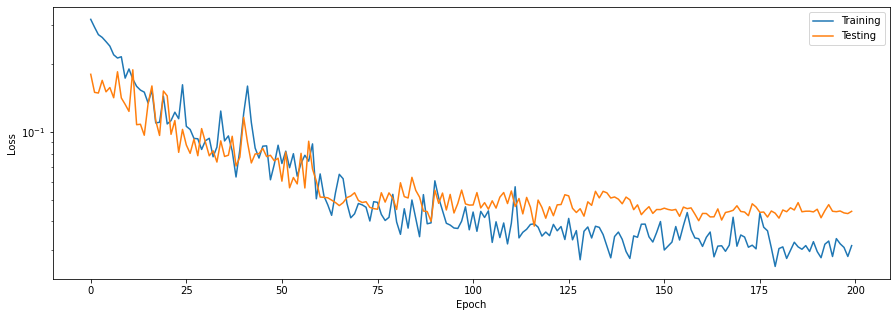

In [8]:
stats.plot(figsize=(15, 5))

# Export the best trained model

Load the best model during training and export it as hdf5 network. It is supported by `lava.lib.dl.netx` to automatically load the network as a lava process.

In [9]:
net.load_state_dict(torch.load(trained_folder + '/network.pt'))
net.export_hdf5(trained_folder + '/network.net')

# Operation count of trained model

Here, we compare the synaptic operation and neuron activity of the trained SDNN and an ANN of iso-architecture.

## Event statistics on testing dataset

In [10]:
counts = []
for i, (input, ground_truth) in enumerate(test_loader):
    _, count = assistant.test(input, ground_truth)
    count = (count.flatten()/(input.shape[-1]-1)/input.shape[0]).tolist() # count skips first events
    counts.append(count) 
    print('\rEvent count : ' + ', '.join([f'{c:.4f}' for c in count]), f'| {stats.testing}', end='') 
        
counts = np.mean(counts, axis=0)

Event count : 2170.5430, 224.2953, 372.4000, 507.9524, 28.2095, 4.7143, 1.0000, 0.1333, 0.4286 | loss =     0.04975 (min =     0.03812)

# Event and Synops comparion with ANN

In [11]:
utils.compare_ops(net, counts, mse=stats.testing.min_loss)

|-----------------------------------------------------------------------------|
|                         |          SDNN           |           ANN           |
|-----------------------------------------------------------------------------|
|         |     Shape     |  Events  |    Synops    | Activations|    MACs    |
|-----------------------------------------------------------------------------|
| layer-0 | (100, 33,  3) |  2475.93 |              |       9900 |            |
| layer-1 | ( 49, 16, 24) |   239.46 |    133700.12 |      18816 |     534600 |
| layer-2 | ( 24,  7, 36) |   422.39 |     19395.86 |       6048 |    1524096 |
| layer-3 | ( 22,  4, 64) |   558.71 |    121649.28 |       5632 |    1741824 |
| layer-4 | ( 20,  2, 64) |    29.90 |    321818.47 |       2560 |    3244032 |
| layer-5 | (  1,  1,100) |     4.80 |      2989.97 |        100 |     256000 |
| layer-6 | (  1,  1, 50) |     1.35 |       240.00 |         50 |       5000 |
| layer-7 | (  1,  1, 10) |     0.16 |  